In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor


<h1>Hyperparameters<h1>


In [71]:
K = 5 # validation folds
ALPHA = 1 #lasso regularization coefficient
MIN_LAG = 120
MAX_LAG = 144
SEED = 42

<h1>Creating DataFrames<h1>

In [72]:
spot_prices = pd.read_csv("spotpriser.csv").set_index("time")
consumption = pd.read_csv("consumption_temp_with_flags.csv").set_index("time")

oslo_consumption = consumption[consumption["location"] == "oslo"]
oslo_consumption = oslo_consumption.merge(spot_prices["oslo"], left_index=True, right_index=True, how="left")
oslo_consumption=oslo_consumption.drop(['location'],axis=1).rename(columns={'oslo':'spot_price'})

stavanger_consumption = consumption[consumption["location"] == "stavanger"]
stavanger_consumption = stavanger_consumption.merge(spot_prices["stavanger"], left_index=True, right_index=True, how="left")
stavanger_consumption=stavanger_consumption.drop(['location'],axis=1).rename(columns={'stavanger':'spot_price'})

trondheim_consumption = consumption[consumption["location"] == "trondheim"]
trondheim_consumption = trondheim_consumption.merge(spot_prices["trondheim"], left_index=True, right_index=True, how="left")
trondheim_consumption=trondheim_consumption.drop(['location'],axis=1).rename(columns={'trondheim':'spot_price'})

tromso_consumption = consumption[consumption["location"] == "tromsø"]
tromso_consumption = tromso_consumption.merge(spot_prices["tromsø"], left_index=True, right_index=True, how="left")
tromso_consumption=tromso_consumption.drop(['location'],axis=1).rename(columns={'tromsø':'spot_price'})

bergen_consumption = consumption[consumption["location"] == "bergen"]
bergen_consumption = bergen_consumption.merge(spot_prices["bergen"], left_index=True, right_index=True, how="left")
bergen_consumption=bergen_consumption.drop(['location'],axis=1).rename(columns={'bergen':'spot_price'})
    

<h1>Feature engineering<h1>

In [73]:
DFS = [oslo_consumption,stavanger_consumption,trondheim_consumption,tromso_consumption,bergen_consumption]

cols_to_standard_normal = ["temperature","consumption"]
cols_to_normalize_01 = ["consumption","spot_price"]
columns_to_decompose = ['temperature', 'spot_price','consumption']
cols_to_diff = []
REVERSE_CONSUMPTION_NORMALIZATION = [] #note: Same order as consumption_dfs

In [74]:
def lag_columns(df, min_lag,max_lag, columns):
    for col in columns:
        if col in df.columns:
            for lag in range(min_lag,max_lag+1):
                df[f"{col}_L{lag}"] =  df[col].shift(lag)
            if col not in ['consumption_seasonal', 'consumption_trend']:
                df.drop(col, axis=1) 
    return df.dropna(axis=0)


def decompose_time_series(df, columns_to_decompose=columns_to_decompose, period=24):
    for col in columns_to_decompose:
        if col in df.columns:
            # Decompose the time series
            result = seasonal_decompose(df[col], model='additive', period=period)

            # Create new columns for trend and seasonal components
            df[f"{col}_trend"] = result.trend
            df[f"{col}_seasonal"] = result.seasonal

            # Drop the original column
            df.drop(col, axis=1, inplace=True)
        else:
            print(f"Column '{col}' not found in DataFrame.")
    
    return df

def add_delta_columns(df,col, delta):
    df[f"{col}_D{delta}"] = df[col]-df.shift(delta)[col]
    return df.dropna() 

In [75]:
for i in range(len(DFS)):
    DFS[i].dropna(axis=0, inplace=True)
    DFS[i]["is_holiday"] = DFS[i]["is_holiday"].astype(int)
    DFS[i]["is_weekend"] = DFS[i]["is_weekend"].astype(int)
    DFS[i].index = pd.to_datetime(DFS[i].index)
    DFS[i]["hour"] = np.cos(DFS[i].index.hour*np.pi/12)
    DFS[i]["month"] = np.cos(DFS[i].index.month*np.pi/6)

    for col in cols_to_standard_normal:
        mu, sig = DFS[i][col].mean(), DFS[i][col].std()
        if col == "consumption":
            REVERSE_CONSUMPTION_NORMALIZATION.append([mu,sig])
        DFS[i][col] = (DFS[i][col]-mu)/sig
    for col in cols_to_normalize_01:
        DFS[i][col] = (DFS[i][col]-DFS[i][col].min())/(DFS[i][col].max()-DFS[i][col].min())
    DFS[i] = decompose_time_series(DFS[i])
    DFS[i] = lag_columns(DFS[i], min_lag=24,max_lag = MAX_LAG, columns=["temperature_trend", "temperature_seasonal", "spot_price_trend", "spot_price_seasonal"])
    DFS[i] = lag_columns(DFS[i], min_lag=MIN_LAG,max_lag = MAX_LAG, columns=["consumption_trend","consumption_seasonal"])
    for col, delta in cols_to_diff:
        DFS[i] = add_delta_columns(DFS[i],col, delta)
    DFS[i] = DFS[i].dropna(axis=0)


/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_38963/2288344897.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_38963/2288344897.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_38963/2288344897.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

<h1>Training<h1>

In [76]:
# k-Fold for validation
k = K
np.random.seed(SEED)
kf = KFold(n_splits=k, shuffle=True,random_state=SEED)

def avoid_spillover_split(X,offset):
    length = len(X)
    indices = np.arange(offset, length+1, MAX_LAG+1)
    return X.iloc[indices]

-2.293780439232107


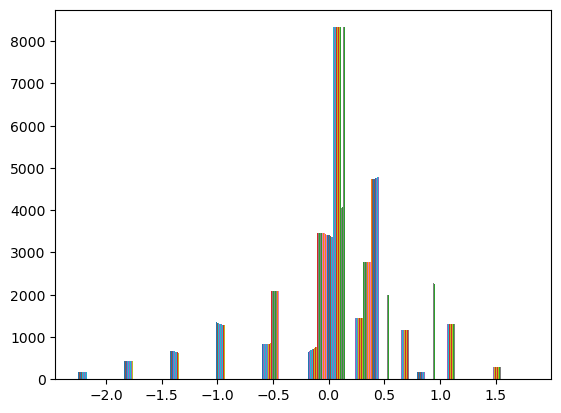

In [77]:
print(min(DFS[0].values.flatten()))
data = DFS[0].iloc[:,]
plt.hist(data)

plt.show()


In [78]:
def cross_validate(data,alpha,mu,sig):
    mape_values = []
    offsets = [1]
    for offset in offsets:
        X = avoid_spillover_split(data,offset=offset)
        y1 = X["consumption_seasonal"]
        y2 = X["consumption_trend"]
        X = X.drop(columns = ["consumption_seasonal","consumption_trend"])
        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y1_train, y1_val = y1.iloc[train_index], y1.iloc[val_index]
            y2_train, y2_val = y2.iloc[train_index], y2.iloc[val_index]

            model1 = Lasso(alpha = alpha)
            model1.fit(X_train, y1_train)
            y1_pred = model1.predict(X_val)

            model2 = Lasso(alpha = alpha)
            model2.fit(X_train, y2_train)
            y2_pred = model2.predict(X_val)

            mape = np.mean(np.abs(((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val)*sig+mu))) * 100
            mape_values.append(mape)
    average_mape = np.mean(mape_values)
        # Averaging MAPE across all folds
    return average_mape

In [79]:
data=DFS[0]
mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[0]

alphas = [0.0001,0.001,0.01,0.1,1,10]
# Grid Search
best_mape = float('inf')
best_hyperparams = None

print("Alpha --> MAPE")
for alpha in alphas:
    average_mape = cross_validate(data,alpha,mu,sig)
    print(f" {average_mape}")
    # Update best hyperparameters if current MAPE is lower
    if average_mape < best_mape:
        best_mape = average_mape
        best_hyperparams = (alpha)

print(f'Best Hyperparameters: {best_hyperparams}')
print(f'Best MAPE: {best_mape}%')




Alpha --> MAPE


KeyError: 'consumption'